# Classification of Digits

## MNIST data

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# Get X and y
X, y = mnist['data'], mnist['target']

In [3]:
# shape of X: 70,000 images with 28x28 size
X.shape

(70000, 784)

In [4]:
# shape of Y: 70,000 labels
y.shape

(70000,)

In [5]:
# view the data
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
some_digit_image.shape


(28, 28)

(-0.5, 27.5, 27.5, -0.5)

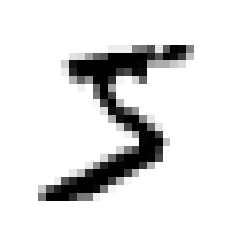

In [6]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")


In [7]:
y[0]

'5'

In [8]:
# convert string to number
import numpy as np
y = y.astype(np.uint8)

In [9]:
y[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [10]:
# split out train and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Lets start with identifying 1 digit, eg., 5

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Use Stochastic Gradient Descent (SGD) to classify whether input is 5 or not

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [13]:
sgd_classifier.predict([some_digit])

array([ True])

### Performance Measures
Use cross_val_score to evaluate train and dev set data

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

If we create a dumb classifier, it will still yield great prediction accuracy. This is because only 10% of
numbers are 5

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_classifier = Never5Classifier()
cross_val_score(never_5_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

This demonstrates why accuracy is generally not the preferred performance measure for classifiers for skewed datasets

#### Confusion Matrix
Evaluate the performance of a classifier using *confusion matrix*

The general idea is how many times the classifier as counted instances of class A as class B

eg. To know the number of times the classifier has confused images of 5s with 3s, look in the 5th row and
3rd column of the confusion matrix

Use cross val predict to use the training set to determine the confusion matrix

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

Use y_train_5 (labels) and y_train_predict to create Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]])

Each row represents an actual class, and each column represents predicted class.

The first row considers non-5 images (the *negative class*): `53,892` were correctly classified (*true negatives*)
The remaining `687` were incorrectly classified as 5s (*false positives*)

The second row considers images of 5s(the *positive class*): `1891` were incorrectly classified as non-5s (*false negatives*),
while the remaining `3530` were classified correctly as 5s (*true positives*)

A perfect classifier would only have true positives and true negatives:

In [19]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

```
precision = TP / (TP + FP)
```

```
Recall or Sensitivity or True Positive Rate (TPR) = TP / (TP + FN)
```

In [20]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_predict)

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_predict)

0.6511713705958311

This means when it claims an image to represent 5, it is correct only `83.71%` (precision) of the time.
It detects only `65.12%` (recall) of the 5s

*F1 score* is the *harmonic mean* of precision and recall
```
F1 = 2 / [(1/precision) + (1/recall)] = 2 * (precision * recall) / (precision + recall) = TP / [TP + (FN + FP)/2]
```

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_predict)

0.7325171197343846

#### Precision Recall Trade-off
Instead of getting predictions, we can get prediction scores and compare it with a threshold

In [23]:
y_scores = sgd_classifier.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([ True])

The SGD classifier uses a threshold of 0, so it returns the same result as `predict()`

In [25]:
threshold = 8000
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([False])

This time, it decreases recall (increases false negative)

In [26]:
# return scores instead of prediction for cross validation to determine which threshold to use
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3,
                             method='decision_function')
y_scores[:5]

array([  1200.93051237, -26883.79202424, -33072.03475406, -15919.5480689 ,
       -20003.53970191])

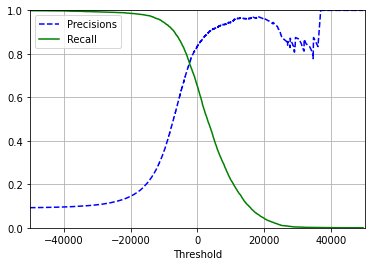

In [27]:
# precision recall curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.grid()
    plt.legend()
    plt.xlabel('Threshold')
    plt.axis([-50000, 50000, 0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)



Get the first value of threshold which gives 90% precision

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439594

Instead of calling classifier's predict():

In [29]:
y_train_pred_90 = (y_scores > threshold_90_precision)

In [30]:
precision_score(y_train_5, y_train_pred_90)


0.9

In [31]:
recall_score(y_train_5, y_train_pred_90)


0.47980077476480354

#### The ROC Curve
Sensitivity (aka Recall) vs 1 - specificity (aka true negative rate)

In [32]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

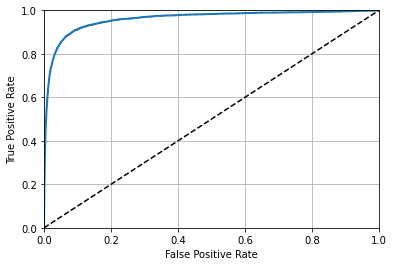

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #dashed diagonal
    plt.grid(True)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.axis([0., 1., 0, 1])

plot_roc_curve(fpr, tpr)

Area under curve (AUC)
Perfect classifier will have ROC AUC equal to 1.
Random classifier will have ROC AUC equal to 0.5

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Random Forest Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

predict_proba() returns an array containing row per instance and a column per class, each containing the probability that the given
instance belongs to the given class

In [36]:
y_proba_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

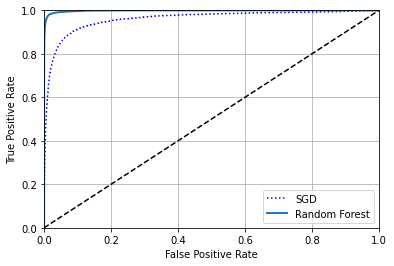

In [37]:
y_scores_forest = y_proba_forest[:, 1] #scores = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [38]:
roc_auc_score(y_train_5, y_scores_forest)


0.9983436731328145

## Multiclass Classification

One vs Rest (OVR) and One vs One (OVO)

### State Vector Machine

In [40]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [41]:
some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [43]:
np.argmax(some_digit_score)

5

In [44]:
svm_clf.classes_


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
svm_clf.classes_[np.argmax(some_digit_score)]


5

Create a OVO vs OVR classifier

In [46]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)


10

### SGD Classifier

In [48]:
sgd_classifier.fit(X_train, y_train)
sgd_classifier.predict([some_digit])

array([3], dtype=uint8)

In [49]:
sgd_classifier.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Calculate the classifier's accuracy using cross validation

In [50]:
cross_val_score(sgd_classifier, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Scaling the input increases the accuracy beyond 85%

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_classifier, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])